# All I want for Christmas is...

[Link to kaggle notebook](https://www.kaggle.com/code/davidandressanchez/all-i-want-for-christmas-is-you)
[Original article](https://mlpills.substack.com/p/issue-40-all-i-want-for-christmas)

Welcome to a Christmas Special issue! Numerous countries across the globe gear up for Christmas celebrations, and what better way to celebrate it than with a festive Data Science project?

Let’s forecast the popularity of the "All I Want for Christmas" search by Mariah Carey on YouTube in the upcoming weeks.

We can get the data from [google trends](https://trends.google.com/trends/explore?date=all_2008&gprop=youtube&q=%2Fm%2F05zrc5&hl=en-GB). The data included with this notebook has been updated in November 2024. Data before 2018 was deleted as data collection wasn't really working at Google yet (apparently).

## Libraries

Spoiler: if you don't take precautions, you'll probably get the following error:

![](files/2024-11-18-14-48-07.png)

The problem is that pmdarima doesn't work with a recent numpy-version. You could downgrade numpy but this might break your other notebooks, so maybe better create a new venv just for arima. Then install the following libraries.

In [11]:
# !pip install numpy==1.26.4
# !pip install pandas
# !pip install matplotlib
# !pip install pmdarima

In [12]:
# just to check

import numpy as np
np.version.version

'1.26.4'

## Data cleaning

First import the data. It's a simple CSV that pandas can handle.

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Read dataset
df = pd.read_csv('files/multiTimeline.csv', header=1)

# Rename columns
df.columns = ['week', 'popularity']

# Inspect data
df.head()

,week,popularity
0,2018-12-23,22
1,2018-12-30,1
2,2019-01-06,<1
3,2019-01-13,<1
4,2019-01-20,<1


Data looks good, but below 1000 views is stored in a non-numerical form. We'll remove the non-numeric values.

In [26]:
df.popularity = df.popularity.replace('<1', 0)
df.head()

,week,popularity
0,2018-12-23,22
1,2018-12-30,1
2,2019-01-06,0
3,2019-01-13,0
4,2019-01-20,0


Check for missing values.

In [27]:
df.isna().sum()

week          0
popularity    0
dtype: int64

None, great! Now fix the data types (if needed).

In [28]:
df.dtypes

week          object
popularity    object
dtype: object

Both are objects where popularity should be an int and week should be a date. The week should also be the index.

In [29]:
df['week'] = pd.to_datetime(df['week'], format='%Y-%m-%d')
df['popularity'] = df['popularity'].astype(int)
df = df.set_index('week')

### Visualize data

Is this a good song to be predicting on?

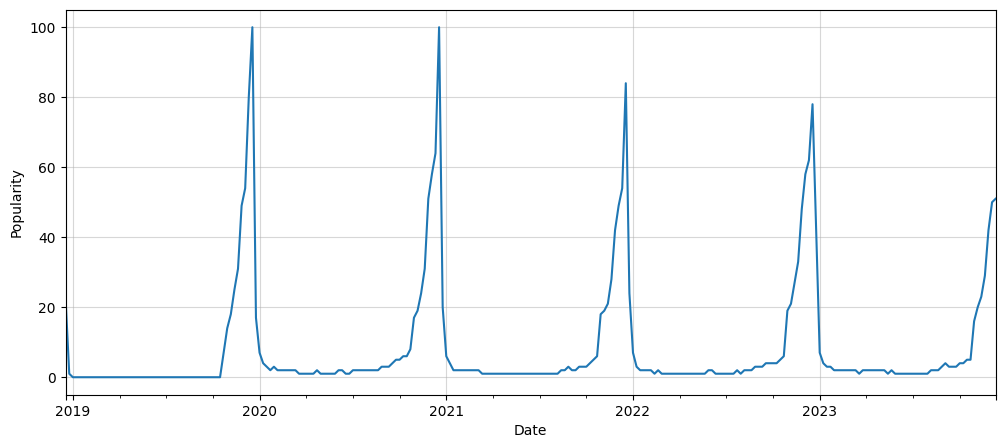

In [30]:
df.popularity.plot(figsize=(12, 5))
plt.grid(True, alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

## The model

Install and import SARIMA library. Arima is a good choice here because there is a definite seasonal part in the data. The downside is Arima has quite a lot of parameters that need to be set correctly, but autoarima fixes that for us.

In [28]:
# Import the library
from pmdarima.arima import auto_arima

Split the data...

In [29]:
samples_train = int(df.shape[0] * 0.9)
train = df.iloc[:samples_train]
test = df.iloc[samples_train:]

Draw a graph of the split.

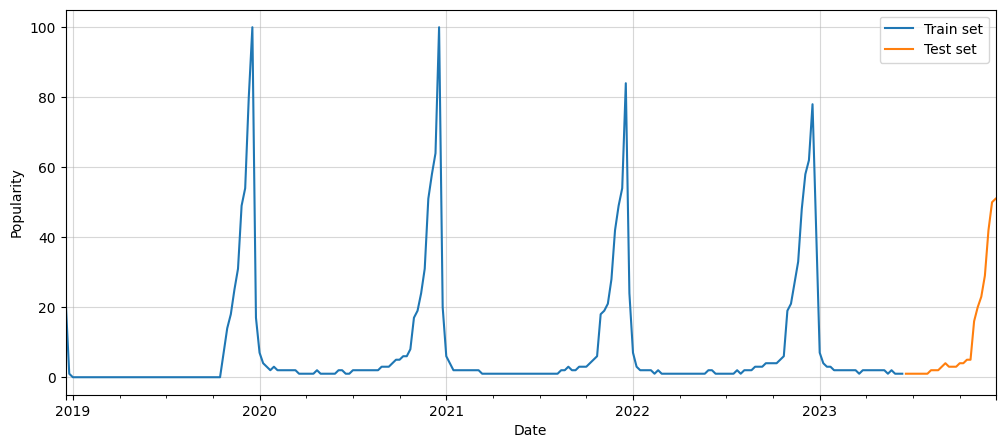

In [30]:
ax = train.popularity.plot(figsize=(12, 5))
test.popularity.plot(ax=ax)
plt.grid(True, alpha=0.5)
plt.legend(['Train set', 'Test set'])
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

### Train your model with the train set

We have weekly data. From the previous graph we can observe annual seasonality. Since a year has 52 weeks, we will select the seasonal period `m` as 52.

In [31]:
# Build and fit the AutoARIMA model
model = auto_arima(train, seasonal=True, m=52, suppress_warnings=True)

# Check the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  234
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 52)   Log Likelihood                -740.491
Date:                                 Mon, 18 Nov 2024   AIC                           1490.982
Time:                                         15:18:15   BIC                           1508.259
Sample:                                     12-23-2018   HQIC                          1497.948
                                          - 06-11-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8669      0.006    139.438      0.000       0.855       0.879
ar.S.L52       0.5030      0.078      6.471      0.000       0.351       0.655
ma.S.L52       0.7471      0.082      9.164      0.000       0.587       0.907
ma.S.L104      0.2839      0.138      2.062      0.039       0.014       0.554
sigma2        22.8169      1.080     21.121      0.000      20.700      24.934
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):             25714.42
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -3.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Check residuals

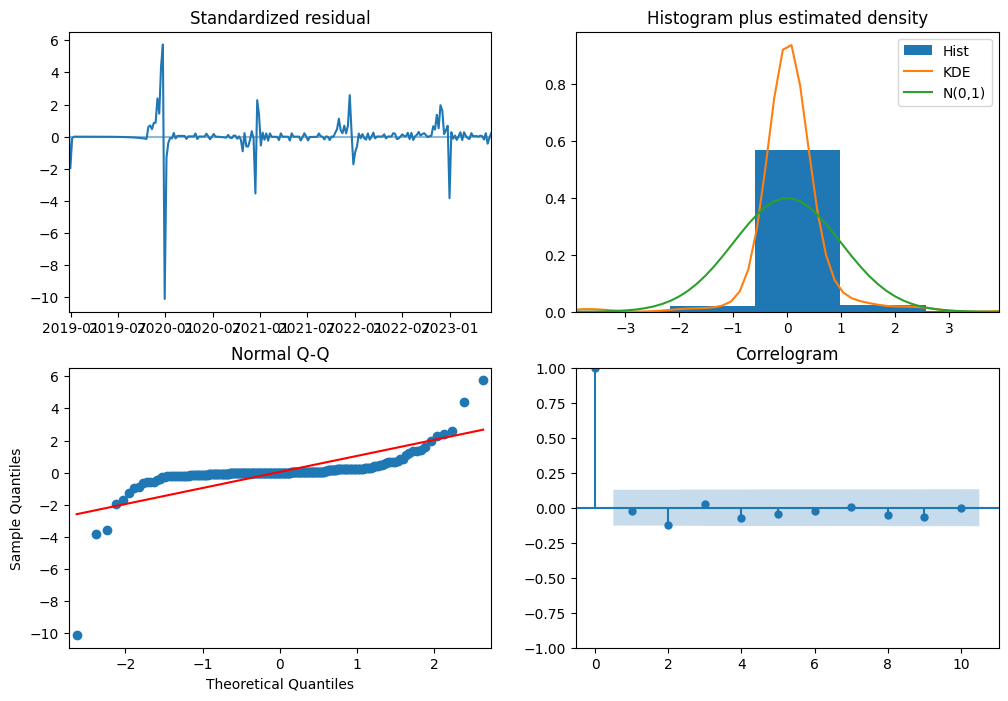

In [32]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

What should these look like ideally?

![](files/2024-11-19-13-51-22.png)


### Make predictions and compare to test set

In [33]:
# Make predictions
predictions = model.predict(n_periods=df.shape[0]-samples_train)

# Format as dataframe
predictions = predictions.to_frame(name='predictions')

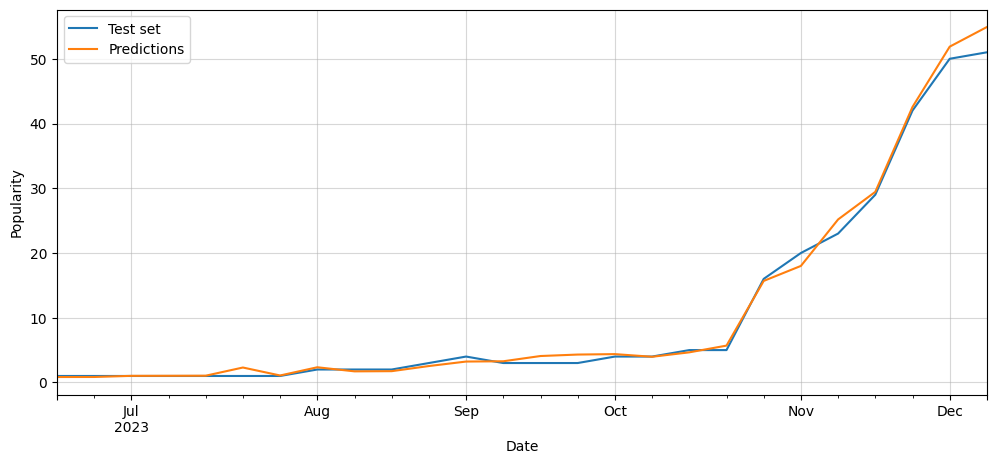

In [34]:
ax = test.popularity.plot(figsize=(12, 5))
predictions.plot(ax=ax)
plt.grid(True, alpha=0.5)
plt.legend(['Test set', 'Predictions'])
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

### Build the final model with all data

In [35]:
# Build and fit the AutoARIMA model
model = auto_arima(df, seasonal=True, m=52, suppress_warnings=True)

# Check the model summary
model.summary()

KeyboardInterrupt: 

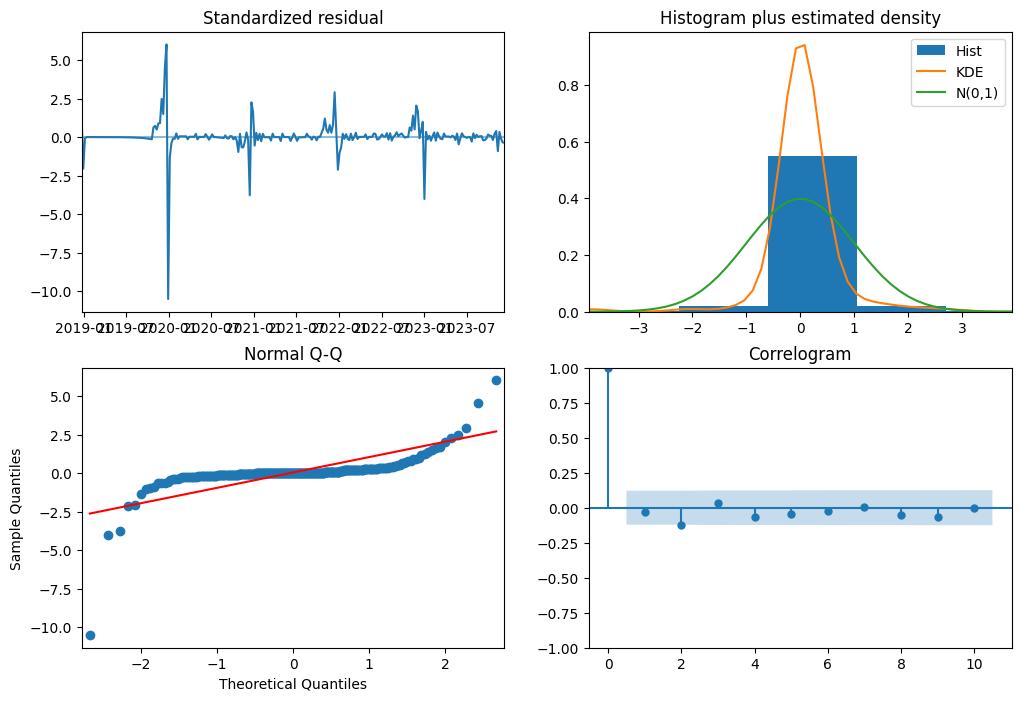

In [116]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

In [113]:
# Make predictions
predictions = model.predict(n_periods=5)

# Format as dataframe
predictions = predictions.to_frame(name='predictions')

### Make your final predictions

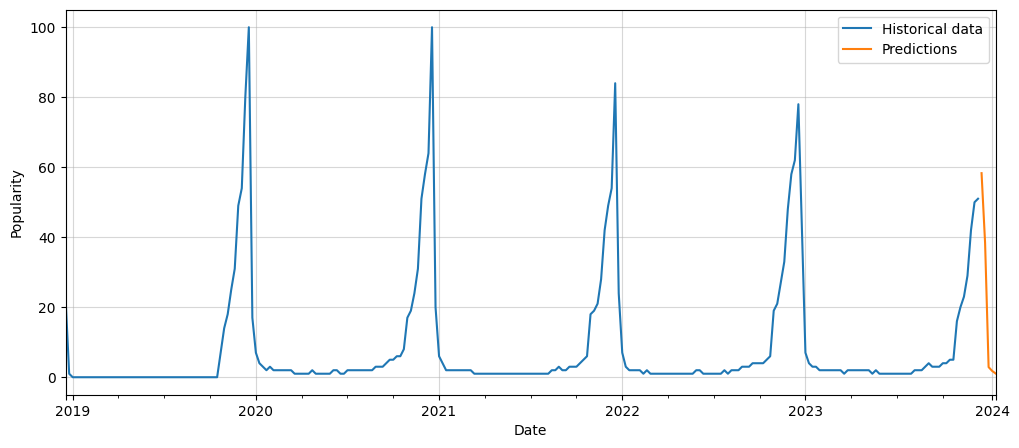

In [20]:
ax = df.popularity.plot(figsize=(12, 5))
predictions.plot(ax=ax)
plt.grid(True, alpha=0.5)
plt.legend(['Historical data', 'Predictions'])
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

In [115]:
predictions.max()

predictions    58.303912
dtype: float64

## Check results

The good thing about rerunning old notebooks is you can check the predictions made vs the actual values. These are stored in "multiTimeline 19-11-2024.csv". Let's load and transform these and check them against the predictions.

In [23]:
# Read dataset
df_new = pd.read_csv('files/multiTimeline 19-11-2024.csv', header=1)

# Rename columns
df_new.columns = ['week', 'popularity']

df_new.popularity = df_new.popularity.replace('<1', 0)
df_new['week'] = pd.to_datetime(df_new['week'], format='%Y-%m-%d')
df_new['popularity'] = df_new['popularity'].astype(int)
df_new = df_new.set_index('week')

# Inspect data
df_new.head()

,popularity
week,
2019-11-17,24
2019-11-24,32
2019-12-01,48
2019-12-08,50
2019-12-15,78


... and visualize!

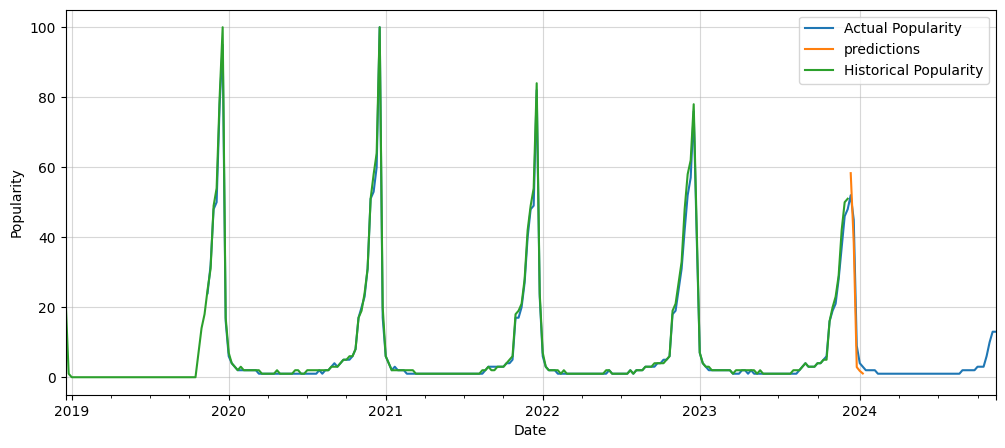

In [31]:
ax = df_new.popularity.plot(figsize=(12, 5), label='Actual Popularity')
predictions.plot(ax=ax, label='Predictions')
df.popularity.plot(ax=ax, label='Historical Popularity')
plt.grid(True, alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

The predicition was, as it seems, dead on.

## Another song?

Now try with another song. Try "always look on the bright side of life" which may or may not be related to easter. Or maybe dead metal songs have a popularity just before Graspop, the metal-festival in Dessel?